In [1]:
import torchvision
import torchvision.transforms as transforms
import torch

transform = transforms.Compose([
    transforms.Resize(28),  # Resize images to 28x28
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize for better GAN training
])

# Load MNIST dataset
dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.48MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.90MB/s]


In [2]:
!pip install tensorflow keras torch torchvision numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)


In [4]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, noise_dim, label_dim, image_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim + label_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, image_dim),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        x = torch.cat([noise, labels], dim=1)
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, image_dim, label_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_dim + label_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        x = torch.cat([img, labels], dim=1)
        return self.model(x)


In [6]:
import torch.optim as optim

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate models with correct image dimensions (64*64 = 4096)
generator = Generator(100, 10, 64*64).to(device)
discriminator = Discriminator(64*64, 10).to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training loop
num_epochs = 50
  # Increased epochs for higher image quality
for epoch in range(num_epochs):
    for real_imgs, labels in dataloader:
        batch_size = real_imgs.shape[0]
        real_imgs = real_imgs.view(batch_size, -1).to(device)
        labels = torch.nn.functional.one_hot(labels, num_classes=10).float().to(device)

        # Train Discriminator
        noise = torch.randn(batch_size, 100).to(device)
        fake_imgs = generator(noise, labels).detach()
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        d_loss_real = criterion(discriminator(real_imgs, labels), real_labels)
        d_loss_fake = criterion(discriminator(fake_imgs, labels), fake_labels)
        d_loss = d_loss_real + d_loss_fake

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        fake_imgs = generator(noise, labels)
        g_loss = criterion(discriminator(fake_imgs, labels), real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch {epoch}/{num_epochs}: D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")


Epoch 0/50: D Loss: 0.49716678261756897, G Loss: 3.7443525791168213
Epoch 1/50: D Loss: 0.48747608065605164, G Loss: 3.4475862979888916
Epoch 2/50: D Loss: 0.526776909828186, G Loss: 4.472297668457031
Epoch 3/50: D Loss: 0.42321497201919556, G Loss: 2.323187828063965
Epoch 4/50: D Loss: 0.3198983669281006, G Loss: 3.8158798217773438
Epoch 5/50: D Loss: 0.40289297699928284, G Loss: 2.6106929779052734
Epoch 6/50: D Loss: 0.44611647725105286, G Loss: 2.1382102966308594
Epoch 7/50: D Loss: 0.5351129174232483, G Loss: 2.184333562850952
Epoch 8/50: D Loss: 0.3764056861400604, G Loss: 4.039387226104736
Epoch 9/50: D Loss: 0.334711492061615, G Loss: 3.7266488075256348
Epoch 10/50: D Loss: 1.2555546760559082, G Loss: 4.520266532897949
Epoch 11/50: D Loss: 0.7013181447982788, G Loss: 2.2732582092285156
Epoch 12/50: D Loss: 0.4414377510547638, G Loss: 3.8312222957611084
Epoch 13/50: D Loss: 1.0082253217697144, G Loss: 4.102505683898926
Epoch 14/50: D Loss: 0.47363606095314026, G Loss: 3.265781879

In [10]:
# Save the Generator and Discriminator models
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')
print("Models saved successfully!")



Models saved successfully!


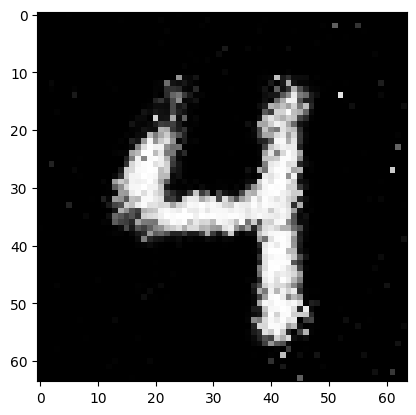

In [9]:
import matplotlib.pyplot as plt

def generate_image(label):
    noise = torch.randn(1, 100).to(device)
    label = torch.nn.functional.one_hot(torch.tensor([label]), num_classes=10).float().to(device)
    # Reshape to 64x64 instead of 28x28
    fake_img = generator(noise, label).detach().cpu().numpy().reshape(64, 64)
    plt.imshow(fake_img, cmap="gray")
    plt.show()

generate_image(4)  # Generates an image of digit 3